In [5]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from skimage import io
import cv2
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from skimage.measure import regionprops

# Add working directory here

In [7]:
from sheepfat import post_process

# Add data 

In [24]:
import sys
sys.path.append('./data/')
print(sys.path[-1])

./data/


# Compare the annotations from KW and DA

## (1) compare # regions per image

In [11]:
annotation_path = "./data/images/DA/H&E/SheepFat_roisPerImage_compare.csv"

In [12]:
df_annotation = pd.read_csv(annotation_path, index_col=1)
df_annotation

,id,number_rois_KW,number_rois_DA,notification
sample,,,,
GTS01.1_OLD_H&E_10x_walluks,0,76.0,58.0,OK
GTS01.4_OLD_H&E_10x_walluks,1,147.0,93.0,OK
JTS01.3_H&E-Bild-Export-03_s1_Walluksneu,2,313.0,313.0,OK
JTS04.3_H&E_10x-Bild-Export-03_s4,3,75.0,93.0,OK
S09.1_DC04_woutleft_H&E_10x_s3,4,NaN,NaN,NaN
S17.B5_DC04_woutright_H&E_10x_s1,5,NaN,NaN,NaN
S20.1_DC07_2395_H&E_10x-Bild-Export-01_s1,6,NaN,NaN,NaN
S29.B4_DC07_weright_H&E_10x_s3,7,NaN,NaN,NaN
S34.3_DC07_544_H&E_10x_s3,8,109.0,45.0,OK


In [13]:
# get rid of single missing rows
df_annotation = df_annotation[(df_annotation['number_rois_KW'].notna()) & (df_annotation['number_rois_DA'].notna())]
df_annotation['relative_difference'] = 1-(df_annotation[['number_rois_KW', 'number_rois_DA']].min(axis=1)/
                                          df_annotation[['number_rois_KW', 'number_rois_DA']].max(axis=1))

df_annotation['rel difference_of_KW'] = (np.abs(df_annotation['number_rois_KW'] - df_annotation['number_rois_DA'])) / df_annotation['number_rois_KW']
df_annotation['rel difference_of_DA'] = (np.abs(df_annotation['number_rois_KW'] - df_annotation['number_rois_DA'])) / df_annotation['number_rois_DA']

df_annotation

/home/jpraetor/anaconda3/envs/tf26/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jpraetor/anaconda3/envs/tf26/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jpraetor/anaconda3/envs/tf26/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,id,number_rois_KW,number_rois_DA,notification,relative_difference,rel difference_of_KW,rel difference_of_DA
sample,,,,,,,
GTS01.1_OLD_H&E_10x_walluks,0,76.0,58.0,OK,0.236842,0.236842,0.310345
GTS01.4_OLD_H&E_10x_walluks,1,147.0,93.0,OK,0.367347,0.367347,0.580645
JTS01.3_H&E-Bild-Export-03_s1_Walluksneu,2,313.0,313.0,OK,0.000000,0.000000,0.000000
JTS04.3_H&E_10x-Bild-Export-03_s4,3,75.0,93.0,OK,0.193548,0.240000,0.193548
S34.3_DC07_544_H&E_10x_s3,8,109.0,45.0,OK,0.587156,0.587156,1.422222
S35.4_SHAM_1068_H&E_10x_s3,9,318.0,234.0,OK,0.264151,0.264151,0.358974
S37.3_SHAM_1128_H&E_10x_s2,11,112.0,76.0,OK,0.321429,0.321429,0.473684
S41.1_Control_1830_H&E_10x_s2,12,483.0,446.0,OK,0.076605,0.076605,0.082960
S42.4_DC04_668 _H&E_10x_s4,13,146.0,93.0,OK,0.363014,0.363014,0.569892


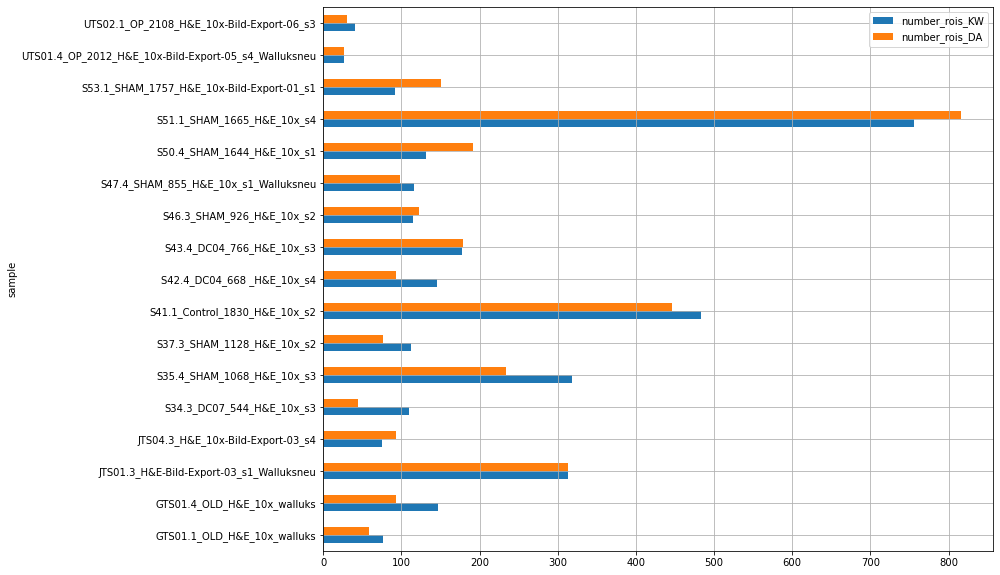

In [18]:
ax = df_annotation[['number_rois_KW', 'number_rois_DA']].plot.barh(figsize=(12,10), grid=True)
# plt.savefig('absolute_number_rois_per_image.png')

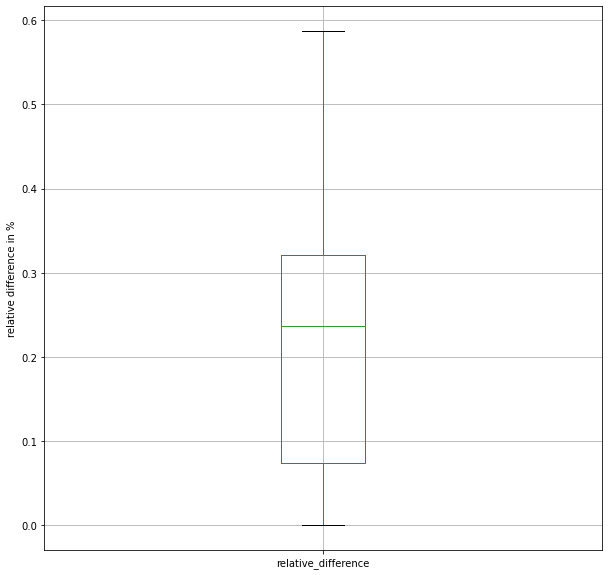

In [21]:
df_annotation.boxplot(column=['relative_difference'], figsize=(10,10), fontsize=10)
plt.ylabel('relative difference in %')
# plt.savefig('relative_difference_number_rois_per_image.png')
plt.show()

## (2) compare the dice-score of overlapping annotations

In [14]:
path_labels_KW = './data/images/KW/H&E/masks/*.*'
path_labels_DA = './data/images/DA/H&E/masks/*.*'

In [15]:
masks_KA = glob(path_labels_KW)
print(*[x.split('/')[-1] for x in np.sort(masks_KA)], sep='\n')  

GTS01.1_OLD_H&E_10x.png
GTS01.4_OLD_H&E_10x.png
JTS01.3_FemurTest_H&E-10x.png
JTS04.3_PCAControl_H&E_10x.png
S34.3_DC07_H&E_10x_s3.png
S35.4_SHAM_H&E_10x_s3.png
S37.3_SHAM_H&E_10x_s2.png
S41.1_Control_H&E_10x_s2.png
S42.4_DC04_H&E_10x_s4.png
S43.4_H&E-Bild-Export-11_s2.png
S46.3_SHAM_H&E_10x_s2.png
S47.4_SHAM_H&E_10x.png
S50.4_SHAM_H&E_10x.png
S51.1_SHAM_H&E_10x.png
S53.1_2_SHAM_H&E_10x.png
UTS01.4_OP_H&E_10x.png
UTS02.1_OP_H&E_10x.png


In [16]:
masks_DA = glob(path_labels_DA)
print(*[x.split('/')[-1] for x in np.sort(masks_DA)], sep='\n')  

GTS01.1_OLD_H&E_10x.png
GTS01.4_OLD_H&E_10x.png
JTS01.3_FemurTest_H&E-10x.png
JTS04.3_PCAControl_H&E_10x.png
S34.3_DC07_H&E_10x_s3.png
S35.4_SHAM_H&E_10x_s3.png
S37.3_SHAM_H&E_10x_s2.png
S41.1_Control_H&E_10x_s2.png
S42.4_DC04_H&E_10x_s4.png
S43.4_H&E-Bild-Export-11_s2.png
S46.3_SHAM_H&E_10x_s2.png
S47.4_SHAM_H&E_10x.png
S50.4_SHAM_H&E_10x.png
S51.1_SHAM_H&E_10x.png
S53.1_2_SHAM_H&E_10x.png
UTS01.4_OP_H&E_10x.png
UTS02.1_OP_H&E_10x.png


In [34]:
def calcuate_measures(df_annot, masks_KW, masks_DA):

    result_list = []

    for sample_idx, _ in df_annot.iterrows():

        abbreviation = sample_idx[:7]

        print(f'\nsample-index <{sample_idx}> with abbreviation: {abbreviation}')

        # get the path
        KW_path = [x for x in masks_KW if abbreviation in x]
        DA_path = [x for x in masks_DA if abbreviation in x]

        if len(KW_path) == 0:
            print(f'no values available for abbrevation <{abbreviation}> in KW_path:', KW_path)
            continue
        if len(DA_path) == 0:
            print(f'no values available for abbrevation <{abbreviation}> in DA_path:', DA_path)
            continue

        KW_path = KW_path[0]
        DA_path = DA_path[0]

        # read the masks
        image_KW = io.imread(KW_path)    
        image_DA = io.imread(DA_path)
            
        print(f'read image with shape {image_KW.shape} from: {KW_path}')
        print(f'read image with shape {image_DA.shape} from: {DA_path}')
        
        # check for same image size
        if image_KA.shape[:2] != image_DA.shape[:2]:
            print(f'no matching image shapes of KW image <{image_KW.shape}> and DA image <{image_DA.shape}>')
            continue

        # flatten the images
        y_KW = image_KW.flatten()
        y_DA = image_DA.flatten()

        # calculate the True-Positive, False-Positive, True-Negative and False-Negative
        tn, fp, fn, tp = confusion_matrix(y_KW, y_DA).ravel()
        print('tn, fp, fn, tp:', tn, fp, fn, tp)
                
        result_list.append([sample_idx, tp, tn, fp, fn])

    df_results = pd.DataFrame(result_list, columns=['sample', 'TruePositive', 'TrueNegative', 'FalsePositive', 'FalseNegative'])
    
    df_results.to_csv('evaluation_results.csv')
    
    print('Finish')
    
    return df_results

In [ ]:
df_metrics = calcuate_measures(df_annot=df_annotation, 
                  masks_KW=masks_KW, 
                  masks_DA=masks_DA)

In [25]:
df_results = pd.read_csv('./data/images/KW-vs-DA_annotation-comparison/evaluation_results.csv', index_col=0)
df_results

,sample,TruePositive,TrueNegative,FalsePositive,FalseNegative
0,GTS01.4_OLD_H&E_10x_walluks,3241821,537292953,632304,2815386
1,JTS01.3_H&E-Bild-Export-03_s1_Walluksneu,16960947,760159839,0,0
2,JTS04.3_H&E_10x-Bild-Export-03_s4,818523,129667935,550089,93453
3,S34.3_DC07_544_H&E_10x_s3,510603,393439392,353814,1982679
4,S35.4_SHAM_1068_H&E_10x_s3,27984225,655047747,1836276,10624392
5,S37.3_SHAM_1128_H&E_10x_s2,4064433,356583228,452967,2720097
6,S41.1_Control_1830_H&E_10x_s2,17383968,501054744,2712411,2482185
7,S42.4_DC04_668 _H&E_10x_s4,5327880,325364256,2671896,2615700
8,S46.3_SHAM_926_H&E_10x_s2,1613697,305002425,731709,825201
9,S47.4_SHAM_855_H&E_10x_s1_Walluksneu,1662465,360249177,694290,807636


In [26]:
df_results['Accuracy'] = (df_results.TruePositive + df_results.TrueNegative) / (df_results.TruePositive + df_results.TrueNegative + df_results.FalsePositive + df_results.FalseNegative) 
df_results['Precision'] = (df_results.TruePositive) / (df_results.TruePositive + df_results.FalsePositive) 
df_results['Recall'] = (df_results.TruePositive) / (df_results.FalseNegative + df_results.TruePositive) 
df_results['Dice_coefficient'] = (2*(df_results.TruePositive)) / ( (2*df_results.TruePositive) + df_results.FalsePositive + df_results.FalseNegative )  
df_results['F_1'] = 2 * (df_results['Precision'] * df_results['Recall']) / (df_results['Precision'] + df_results['Recall'])

#df_results['Matthews_correlation_coefficient'] = ((df_results.TruePositive * df_results.TrueNegative) - (df_results.FalsePositive + df_results.FalseNegative)) / np.sqrt( (df_results.TruePositive + df_results.FalsePositive) * (df_results.TruePositive + df_results.FalseNegative) * (df_results.TrueNegative + df_results.FalsePositive) * (df_results.TrueNegative + df_results.FalseNegative) ) 
df_results

,sample,TruePositive,TrueNegative,FalsePositive,FalseNegative,Accuracy,Precision,Recall,Dice_coefficient,F_1
0,GTS01.4_OLD_H&E_10x_walluks,3241821,537292953,632304,2815386,0.993662,0.836788,0.535201,0.652847,0.652847
1,JTS01.3_H&E-Bild-Export-03_s1_Walluksneu,16960947,760159839,0,0,1.000000,1.000000,1.000000,1.000000,1.000000
2,JTS04.3_H&E_10x-Bild-Export-03_s4,818523,129667935,550089,93453,0.995092,0.598068,0.897527,0.717818,0.717818
3,S34.3_DC07_544_H&E_10x_s3,510603,393439392,353814,1982679,0.994104,0.590691,0.204792,0.304139,0.304139
4,S35.4_SHAM_1068_H&E_10x_s3,27984225,655047747,1836276,10624392,0.982084,0.938422,0.724818,0.817904,0.817904
5,S37.3_SHAM_1128_H&E_10x_s2,4064433,356583228,452967,2720097,0.991278,0.899728,0.599074,0.719246,0.719246
6,S41.1_Control_1830_H&E_10x_s2,17383968,501054744,2712411,2482185,0.990080,0.865030,0.875055,0.870013,0.870013
7,S42.4_DC04_668 _H&E_10x_s4,5327880,325364256,2671896,2615700,0.984262,0.666004,0.670715,0.668351,0.668351
8,S46.3_SHAM_926_H&E_10x_s2,1613697,305002425,731709,825201,0.994948,0.688025,0.661650,0.674580,0.674580
9,S47.4_SHAM_855_H&E_10x_s1_Walluksneu,1662465,360249177,694290,807636,0.995867,0.705404,0.673035,0.688840,0.688840


In [27]:
# tranfer a column into a row
df_boxplot = pd.melt(df_results, id_vars=['sample'], value_vars=['Accuracy', 'Precision', 'Recall', 'Dice_coefficient', 'F_1'])

df_boxplot.head()

,sample,variable,value
0,GTS01.4_OLD_H&E_10x_walluks,Accuracy,0.993662
1,JTS01.3_H&E-Bild-Export-03_s1_Walluksneu,Accuracy,1.000000
2,JTS04.3_H&E_10x-Bild-Export-03_s4,Accuracy,0.995092
3,S34.3_DC07_544_H&E_10x_s3,Accuracy,0.994104
4,S35.4_SHAM_1068_H&E_10x_s3,Accuracy,0.982084


/home/jpraetor/anaconda3/envs/tf26/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


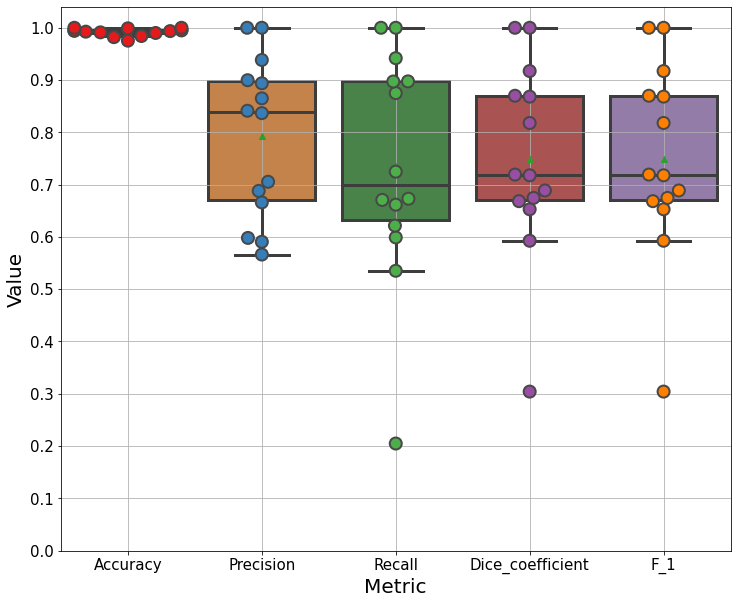

In [28]:
plt.figure(figsize=(12,10))
ax = sns.boxplot(x='variable',y='value', data=df_boxplot, saturation=0.5, notch=False, linewidth=3, showmeans=True)
ax = sns.swarmplot(x='variable',y='value', data=df_boxplot, size=12, alpha=1, dodge=True, palette=sns.color_palette("Set1"), edgecolor='gray', linewidth=2) 

ax.set_xlabel("Metric",fontsize=20)
ax.set_ylabel("Value",fontsize=20)
ax.set_yticks(np.arange(start=0, stop=1.1, step=0.1))
ax.tick_params(labelsize=15)
plt.grid(True)

# plt.savefig('scores_between_overlaps.png', dpi=300)
plt.show()

## (3) compare the distributions of annotated ROIs

In [35]:
def determine_annotated_sizes(df_annot, masks_KW, masks_DA):

    sizes_KW = []
    sizes_Da = []
    
    for sample_idx, _ in df_annot.iterrows():

        abbreviation = sample_idx[:7]

        print(f'\nsample-index <{sample_idx}> with abbreviation: {abbreviation}')

        # get the path
        KW_path = [x for x in masks_KW if abbreviation in x]
        DA_path = [x for x in masks_DA if abbreviation in x]

        if len(KW_path) == 0:
            print(f'no values available for abbrevation <{abbreviation}> in KW:', KW_path)
            continue
        if len(DA_path) == 0:
            print(f'no values available for abbrevation <{abbreviation}> in DA_path:', DA_path)
            continue
            
        KW_path = KW_path[0]
        DA_path = DA_path[0]

        # read the masks
        try:
            image_KW = skimage.io.imread(KW_path)
            image_KW = skimage.color.rgb2gray(image_KW)
        except:
            image_KW = cv2.imread(KW_path, 0)
            
        try:
            image_DA = skimage.io.imread(DA_path)
            image_DA = skimage.color.rgb2gray(image_DA)
        except:
            image_DA = cv2.imread(DA_path, 0)
            
        print(f'read image with shape {image_KW.shape} from: {KW_path}')
        print(f'read image with shape {image_DA.shape} from: {DA_path}')
        
        # check for same image size
        if image_KW.shape[:2] != image_DA.shape[:2]:
            print(f'no matching image shapes of KW image <{image_KW.shape}> and DA image <{image_DA.shape}>')
            continue
               
        # get the number of rois in both masks
        num_labels_KW, image_KW_label = cv2.connectedComponents(image_KW)
        num_labels_DA, image_DA_label = cv2.connectedComponents(image_DA)
        
        # extract all areas of KW and DA
        regions_KW = regionprops(image_KW_label)        
        tmp_sizes_KW = [props.area for props in regions_KW]
        
        regions_DA = regionprops(image_DA_label)    
        tmp_sizes_DA = [props.area for props in regions_DA]
        
        # collect all sizes per user together
        sizes_KW.extend(tmp_sizes_KW)
        sizes_DA.extend(tmp_sizes_DA)
        
        print(f'# KWs ROIs:: {num_labels_KW-1} - # DAs ROIs: {num_labels_DA-1}')            
    
        
    df_sizes = pd.DataFrame([sizes_KW, sizes_DA]).T 
    df_sizes.to_csv('size_distributions.csv')
    print('finish')
    
    return df_sizes

In [ ]:
df_obj_sizes = determine_annotated_sizes(df_annot=df_annotation, 
                                          masks_KW=masks_KW, 
                                          masks_DA=masks_DA)

In [20]:
df_obj_sizes = pd.read_csv('size_distributions.csv', index_col=0)
df_obj_sizes

,0,1
0,17633.0,4028.0
1,5234.0,2467.0
2,284481.0,18380.0
3,15422.0,14632.0
4,5384.0,21647.0
...,...,...
2857,6971.0,NaN
2858,720.0,NaN
2859,1313.0,NaN
2860,5713.0,NaN


In [ ]:
df_obj_sizes = df_obj_sizes.T
df_obj_sizes.columns = ['sizes_KW', 'sizes_DA']
df_obj_sizes

In [ ]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(12,10), dpi= 80)
sns.distplot(df_obj_sizes.sizes_KW, color="dodgerblue", label="Compact", **kwargs)
sns.distplot(df_obj_sizes.sizes_DA, color="orange", label="SUV", **kwargs)
#plt.xlim(-1,df_obj_sizes.max().max())
plt.legend()
plt.savefig('sizes_distribution_full.png', dpi=300)
plt.show()

In [ ]:
filter_min = 1
df_obj_sizes_filtered = df_obj_sizes[ (df_obj_sizes.sizes_KW > filter_min) & (df_obj_sizes.sizes_DA > filter_min) ]
df_obj_sizes_filtered

In [ ]:
plt.figure(figsize=(25,12), dpi= 80)
df_obj_sizes_filtered.sizes_KW.hist(color="orange", label='KW')
df_obj_sizes_filtered.sizes_DA.hist(color="dodgerblue", label='DA')
plt.xlabel('sizes', fontsize=20)
#plt.yticks(np.arange(0,np.max([df_obj_sizes_filtered.sizes_KW.max().max(), df_obj_sizes_filtered.sizes_DA.max().max()]), step=3000))
plt.legend()
plt.savefig('sizes_distribution_filtered.png', dpi=300)
plt.show()

# Evaluate the OilRed Color thresholding

In [30]:
%%time

img_original = io.imread('./data/images/KW/OilRed/inputs/S50.4_SHAM_OilRed_10x_walluks.tif')
img_true = io.imread('./data/images/KW/OilRed/masks/S50.4_OilRed-Bild-Export-14_s3_mask_deprecated.png', 0)
img_pred = io.imread('./data/prediction/Oil-Red/binary/S50.4_SHAM_OilRed_10x_walluks.png')

print(img_original.shape, img_true.shape, img_pred.shape)

(7633, 10166, 3) (7633, 10166) (7633, 10166)
CPU times: user 399 ms, sys: 287 ms, total: 686 ms
Wall time: 2.95 s


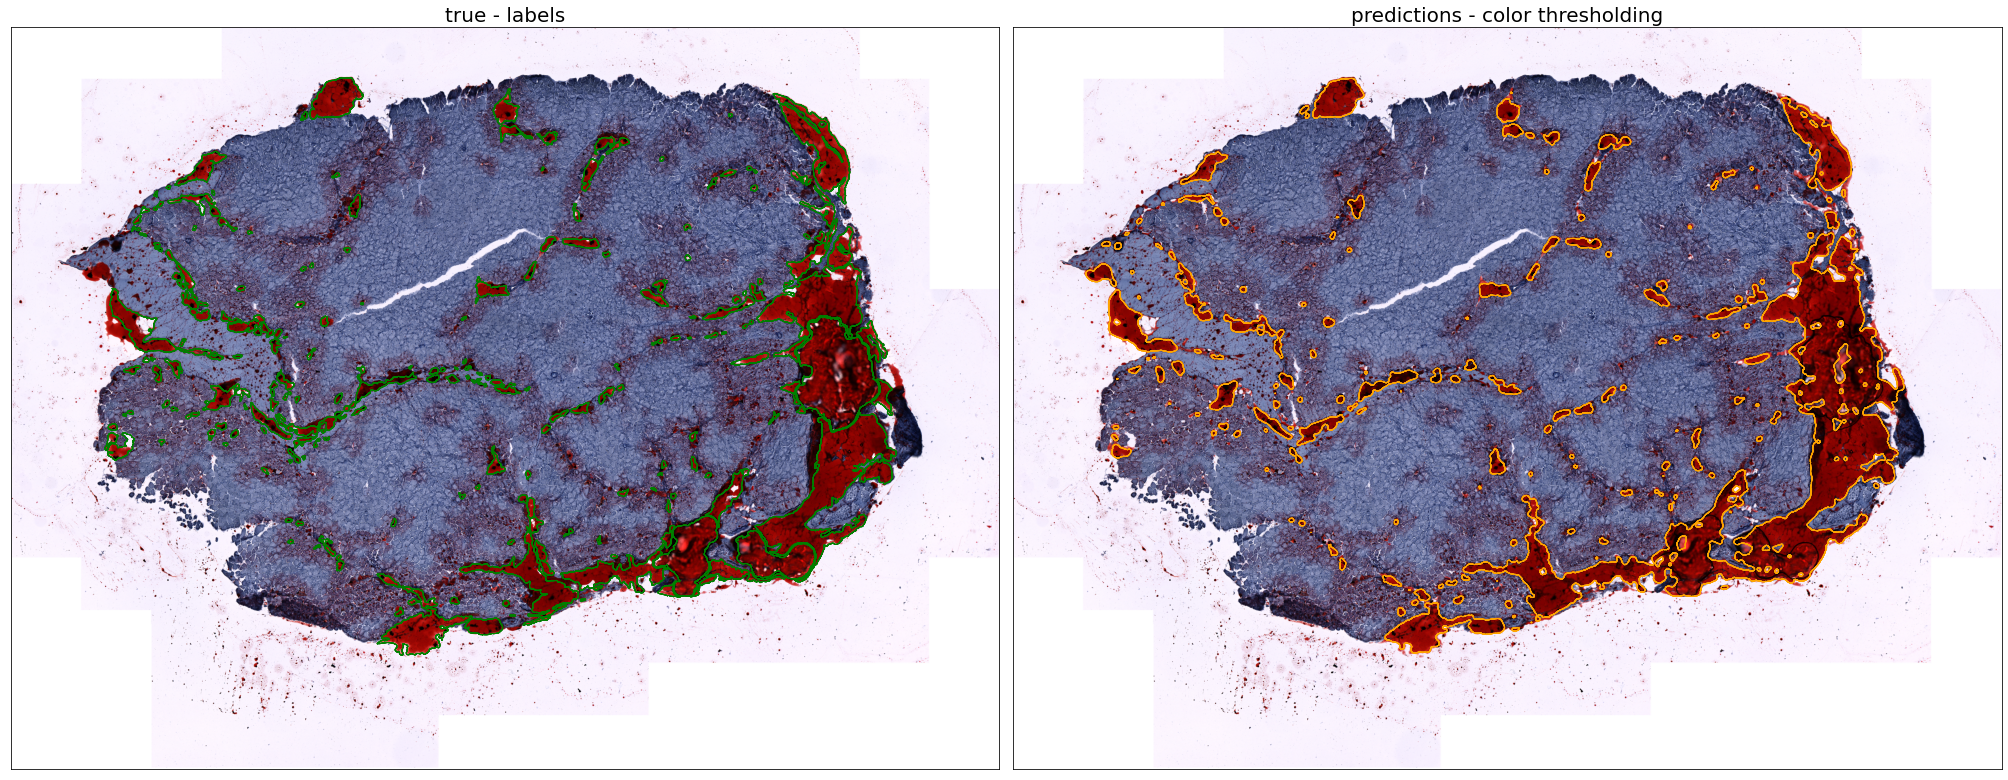

In [31]:
# using tuple unpacking for multiple Axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28,16))

ax1.imshow(img_original)
ax1.contour(img_true, colors='green', linewidths=1)
ax1.set_title("true - labels", fontsize=20)

ax2.imshow(img_original)
ax2.contour(img_pred, colors='orange', linewidths=1)
ax2.set_title("predictions - color thresholding", fontsize=20)

ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
# plt.savefig('Color_thresholding_comparison.png', dpi=300)
plt.show()

In [32]:
y_true = img_true.flatten()
y_pred = img_pred.flatten()

In [33]:
acc_score = metrics.accuracy_score(y_true, y_pred)
prec_score, rec_score, F1_score, support_score = metrics.precision_recall_fscore_support(y_true, y_pred)

print(f'Accuracy: {acc_score} - Precision: {prec_score} - Recall: {rec_score} - F_1: {F1_score}')

Accuracy: 0.9783078687576354 - Precision: [0.98861582 0.84062145] - Recall: [0.98807459 0.84681726] - F_1: [0.98834513 0.84370798]


# (4) Determine the kappa statistic as interobserver agreement measurement

[Understanding Interobserver Agreement: The Kappa Statistic - paper](http://web2.cs.columbia.edu/~julia/courses/CS6998/Interrater_agreement.Kappa_statistic.pdf)<br>
[sklearn.metrics.cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)<br>
Used sklearn - method which returns: "The kappa statistic, which is a number between -1 and 1. The maximum value means complete agreement; zero or lower means chance agreement."

In [38]:
from sklearn.metrics import cohen_kappa_score

In [34]:
# get KWs mask images
masks_KW = glob('./data/images/KW/H&E/masks/*.*')
masks_KW

['./data/images/KW/H&E/masks/GTS01.4_OLD_H&E_10x.png',
 './data/images/KW/H&E/masks/JTS01.3_FemurTest_H&E-10x.png',
 './data/images/KW/H&E/masks/GTS01.1_OLD_H&E_10x.png',
 './data/images/KW/H&E/masks/S34.3_DC07_H&E_10x_s3.png',
 './data/images/KW/H&E/masks/S37.3_SHAM_H&E_10x_s2.png',
 './data/images/KW/H&E/masks/S50.4_SHAM_H&E_10x.png',
 './data/images/KW/H&E/masks/JTS04.3_PCAControl_H&E_10x.png',
 './data/images/KW/H&E/masks/S53.1_2_SHAM_H&E_10x.png',
 './data/images/KW/H&E/masks/S46.3_SHAM_H&E_10x_s2.png',
 './data/images/KW/H&E/masks/S43.4_H&E-Bild-Export-11_s2.png',
 './data/images/KW/H&E/masks/S41.1_Control_H&E_10x_s2.png',
 './data/images/KW/H&E/masks/S47.4_SHAM_H&E_10x.png',
 './data/images/KW/H&E/masks/S35.4_SHAM_H&E_10x_s3.png',
 './data/images/KW/H&E/masks/S42.4_DC04_H&E_10x_s4.png',
 './data/images/KW/H&E/masks/UTS02.1_OP_H&E_10x.png',
 './data/images/KW/H&E/masks/UTS01.4_OP_H&E_10x.png',
 './data/images/KW/H&E/masks/S51.1_SHAM_H&E_10x.png']

In [35]:
# get DAs mask images
masks_DA = glob('./data/images/DA/H&E/masks/*.*')
masks_DA

['./data/images/DA/H&E/masks/GTS01.4_OLD_H&E_10x.png',
 './data/images/DA/H&E/masks/JTS01.3_FemurTest_H&E-10x.png',
 './data/images/DA/H&E/masks/GTS01.1_OLD_H&E_10x.png',
 './data/images/DA/H&E/masks/S34.3_DC07_H&E_10x_s3.png',
 './data/images/DA/H&E/masks/S37.3_SHAM_H&E_10x_s2.png',
 './data/images/DA/H&E/masks/S50.4_SHAM_H&E_10x.png',
 './data/images/DA/H&E/masks/JTS04.3_PCAControl_H&E_10x.png',
 './data/images/DA/H&E/masks/S53.1_2_SHAM_H&E_10x.png',
 './data/images/DA/H&E/masks/S46.3_SHAM_H&E_10x_s2.png',
 './data/images/DA/H&E/masks/S43.4_H&E-Bild-Export-11_s2.png',
 './data/images/DA/H&E/masks/S41.1_Control_H&E_10x_s2.png',
 './data/images/DA/H&E/masks/S47.4_SHAM_H&E_10x.png',
 './data/images/DA/H&E/masks/S35.4_SHAM_H&E_10x_s3.png',
 './data/images/DA/H&E/masks/S42.4_DC04_H&E_10x_s4.png',
 './data/images/DA/H&E/masks/UTS02.1_OP_H&E_10x.png',
 './data/images/DA/H&E/masks/UTS01.4_OP_H&E_10x.png',
 './data/images/DA/H&E/masks/S51.1_SHAM_H&E_10x.png']

In [ ]:
print(len(masks_KW), len(masks_DA))

all_kappa_scores = []

for idx, path_KW in enumerate(masks_KW):
    
    # create abbreviation to merge both files
    abbrevation = path_KW.split('/')[-1].split('_')[0] 
    print('\n[{0} / {1}] - abbrevation: {2}'.format(idx, len(masks_KW)-1, abbrevation))

    print('path from KW', path_KW)
    path_DA = [x for x in masks_DA if abbrevation in x][0]
    print('path from DA', path_DA)

    try:
        img_KW = io.imread(path_KW)
    except:
        img_KW = cv2.imread(path_KW, 0)
    try:
        img_DA = io.imread(path_DA)
    except:
        img_DA = cv2.imread(path_DA, 0)
    print(f'img-KW-shape: {img_KW.shape} - img-DA-shape: {img_DA.shape} - both shapes match: {img_KW.shape==img_DA.shape}')
    
    arr_KW = img_KW.flatten()
    arr_DA = img_DA.flatten()
    
    shapes_match = len(arr_KW)==len(arr_DA)
    print(f'arr-KW-shape: {arr_KW.shape} with unique values: {np.unique(arr_KW)}')
    print(f'arr-DA-shape: {arr_DA.shape} with unique values: {np.unique(arr_DA)}')

    if not shapes_match:
        print('[CAUTION] shapes does not match - skip sample')
        continue
    
    kappa_score = cohen_kappa_score(arr_KW, arr_DA)
    print(f'kappa score: {kappa_score}')
    
    all_kappa_scores.append([abbrevation, kappa_score])   

In [ ]:
try:
    df_kappa_score = pd.DataFrame(all_kappa_scores, columns=['abbreviation', 'kappa_score'])
except:
    df_kappa_score = pd.read_csv('./data/images/KW-vs-DA_annotation-comparison/kappa_score_KW_DA_annotation.csv')
    
df_kappa_score

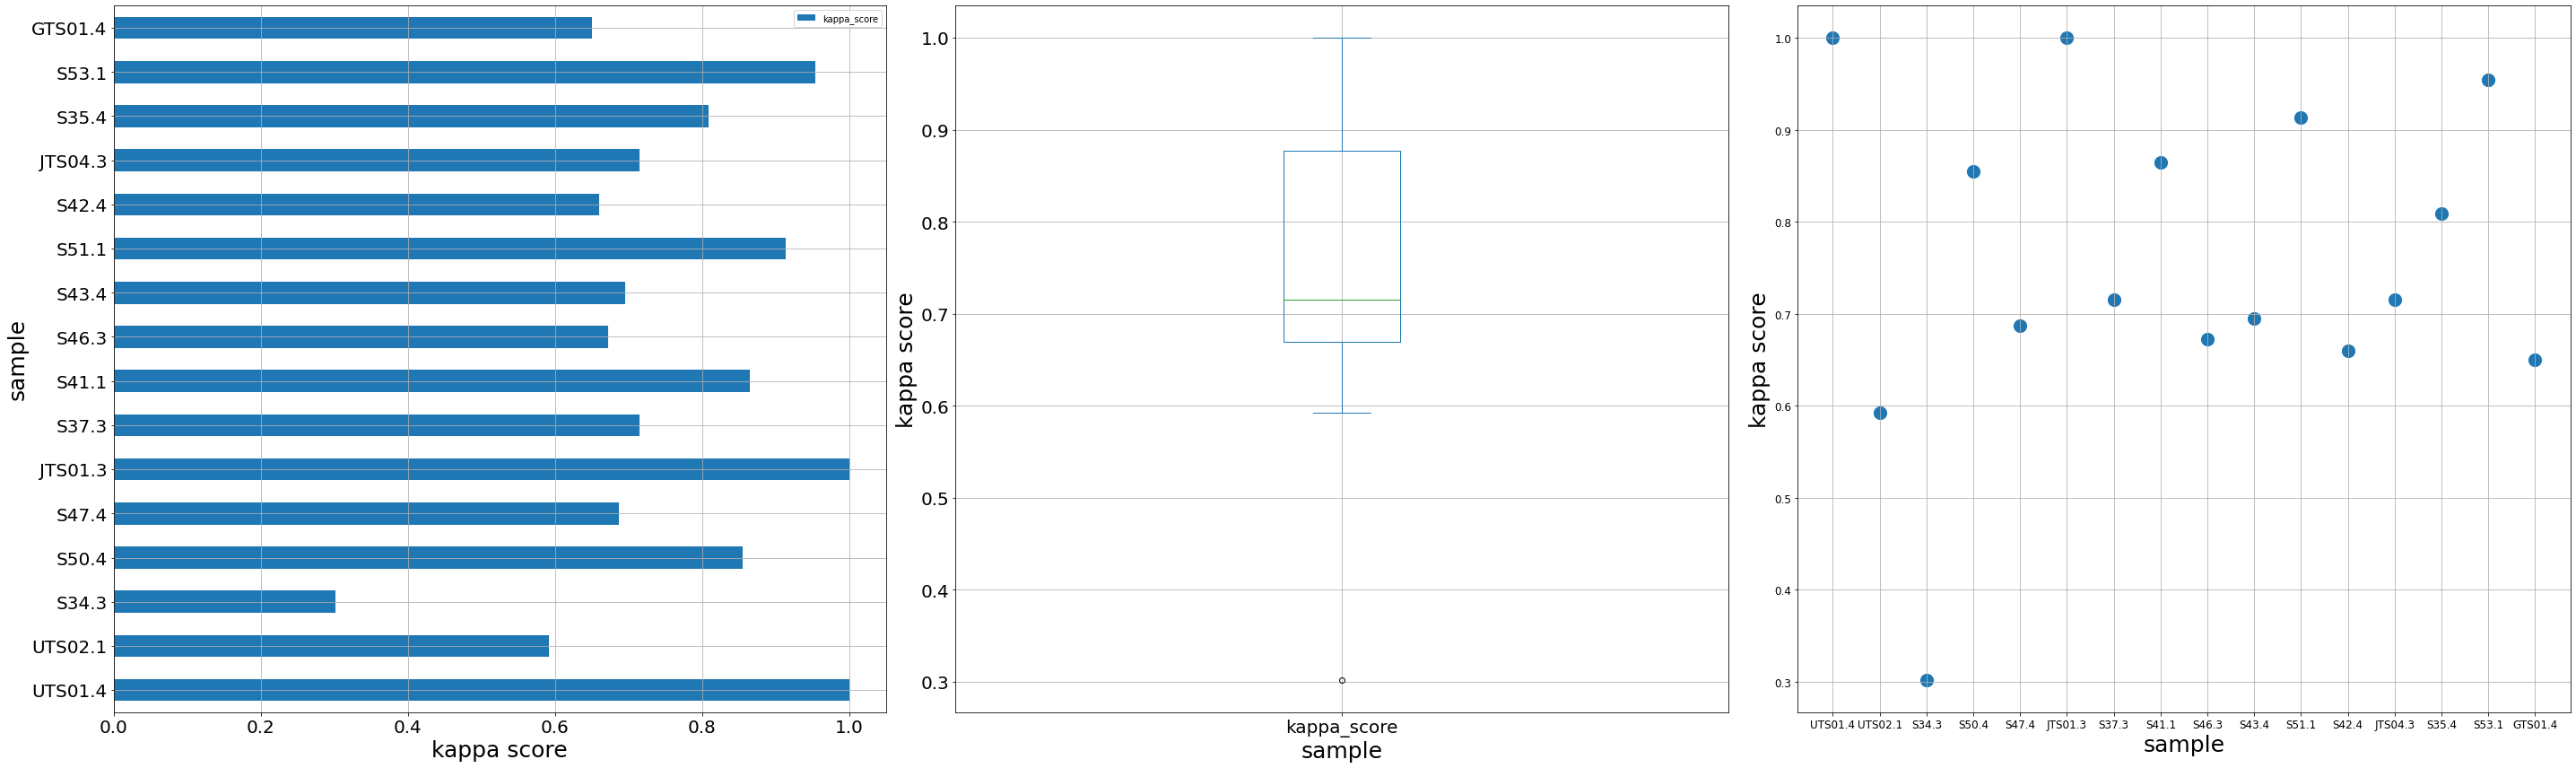

In [66]:
fig, ax_arr = plt.subplots(1, 3, figsize=(40, 12))    
ax1, ax2, ax3 = ax_arr.ravel()

ax1 = df_kappa_score.plot.barh(x='abbreviation', y='kappa_score', grid=True, fontsize=20, ax=ax1)
ax1.set_xlabel('kappa score', fontsize=25)
ax1.set_ylabel('sample', fontsize=25)

ax2 = df_kappa_score.plot(x='abbreviation', y='kappa_score', kind='box', grid=True, fontsize=20, ax=ax2)
ax2.set_xlabel('sample', fontsize=25)
ax2.set_ylabel('kappa score', fontsize=25)

ax3 = df_kappa_score.plot(x='abbreviation', y='kappa_score', kind='scatter', grid=True, fontsize=12, ax=ax3, s=200, colormap='viridis')
ax3.set_xlabel('sample', fontsize=25)
ax3.set_ylabel('kappa score', fontsize=25)

plt.tight_layout()    
#plt.savefig('/asbdata/Philipp/SheepFat/kappa_score_KW_DA_annotations.png')
plt.show()

# (5) Analyse the OilRed thresholdings

In [38]:
fat_path = [glob('./data/quantification/fat/Oil-Red/Data/*')]
fat_path.sort()
print(len(fat_path))
fat_path

1


[['./data/quantification/fat/Oil-Red/Data/#Dataset=GTS01.1_OLD_OilRed_10x_walluks_Min Threshold B=0_Min Threshold H=0_Max Threshold H=256_Min Threshold S=[ 40 , 200 , [  40  ,  200  ] ]_Max Threshold B=256_Max Threshold S=256.csv',
  './data/quantification/fat/Oil-Red/Data/#Dataset=S37.3_SHAM_oil Red_10x_s2_walluks_Min Threshold B=0_Min Threshold H=0_Max Threshold H=256_Min Threshold S=[ 40 , 200 , [  40  ,  200  ] ]_Max Threshold B=256_Max Threshold S=256.csv',
  './data/quantification/fat/Oil-Red/Data/#Dataset=UTS01.4_OP_OilRed_10x_walluks_Min Threshold B=0_Min Threshold H=0_Max Threshold H=256_Min Threshold S=[ 40 , 200 , [  40  ,  200  ] ]_Max Threshold B=256_Max Threshold S=256.csv',
  './data/quantification/fat/Oil-Red/Data/#Dataset=UTS02.1_OP_OilRed_10x_walluks_Min Threshold B=0_Min Threshold H=0_Max Threshold H=256_Min Threshold S=[ 40 , 200 , [  40  ,  200  ] ]_Max Threshold B=256_Max Threshold S=256.csv',
  './data/quantification/fat/Oil-Red/Data/#Dataset=S34.3_DC07_OilRed_10

In [39]:
tissue_path = [glob('./data/quantification/tissue_mask/Oil-Red/*')]
tissue_path.sort()
print(len(tissue_path))
tissue_path

1


[['./data/quantification/tissue_mask/Oil-Red/#Dataset=JTS01.3_FemurTest_OilRed-10x_walluk.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=GTS01.4_OLD_OilRed_10x_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=UTS01.4_OP_OilRed_10x_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S46.3_SHAM_OilRed_10x_s2_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S42.4_DC04_OilRed_10x_s4_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S53.1_SHAM_OilRed_10x_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S47.4_SHAM_OilRed_10x_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S50.4_SHAM_OilRed_10x_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S37.3_SHAM_oil Red_10x_s2_walluks.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=S43.4_OilRed-Bild-Export-11_s2.csv',
  './data/quantification/tissue_mask/Oil-Red/#Dataset=JTS04.3_PCAControl_OilRed_10

In [70]:
# analyse the tables
df_results = post_process.evaluate_oilred(tissue_path, fat_path)
#df_results.to_csv('./data/images/KW/OilRed/oilred_fat_fractions.csv')
df_results

[0] # of tissue-path: 17 - # of fat-path: 17
[1.0] df-tissue-path: GTS01.1_OLD_Oil - df-fat-path: GTS01.1_OLD_Oil
[1.1] df-tissue-shape: (1, 6) - df-fat-shape: (1523, 6)
[1.2] tissue-area-sum: 47802144 - fat-area-sum: 3681958 - fat-fraction: 0.07702495519866222
[1.0] df-tissue-path: GTS01.4_OLD_Oil - df-fat-path: GTS01.4_OLD_Oil
[1.1] df-tissue-shape: (1, 6) - df-fat-shape: (3809, 6)
[1.2] tissue-area-sum: 35627074 - fat-area-sum: 3788749 - fat-fraction: 0.10634465799801578
[1.0] df-tissue-path: JTS01.3_FemurTe - df-fat-path: JTS01.3_FemurTe
[1.1] df-tissue-shape: (245, 6) - df-fat-shape: (609, 6)
[1.2] tissue-area-sum: 36882053 - fat-area-sum: 2357907 - fat-fraction: 0.0639310127340254
[1.0] df-tissue-path: JTS04.3_PCACont - df-fat-path: JTS04.3_PCACont
[1.1] df-tissue-shape: (1, 6) - df-fat-shape: (2508, 6)
[1.2] tissue-area-sum: 38780621 - fat-area-sum: 3147680 - fat-fraction: 0.08116631242186659
[1.0] df-tissue-path: S34.3_DC07_OilR - df-fat-path: S34.3_DC07_OilR
[1.1] df-tissue-sh

,file,total-tissue-area,total-fat-area,fat-fraction
0,GTS01.1_OLD_Oil,47802144,3681958,0.077025
1,GTS01.4_OLD_Oil,35627074,3788749,0.106345
2,JTS01.3_FemurTe,36882053,2357907,0.063931
3,JTS04.3_PCACont,38780621,3147680,0.081166
4,S34.3_DC07_OilR,75158489,4732986,0.062973
5,S35.3_OilRed-Bi,62216402,7784414,0.125118
6,S37.3_SHAM_oil,36240757,2085892,0.057557
7,S41.1_Control_O,50182417,3906789,0.077852
8,S42.4_DC04_OilR,32271693,8223387,0.254817
9,S43.4_OilRed-Bi,49571949,5732957,0.115649


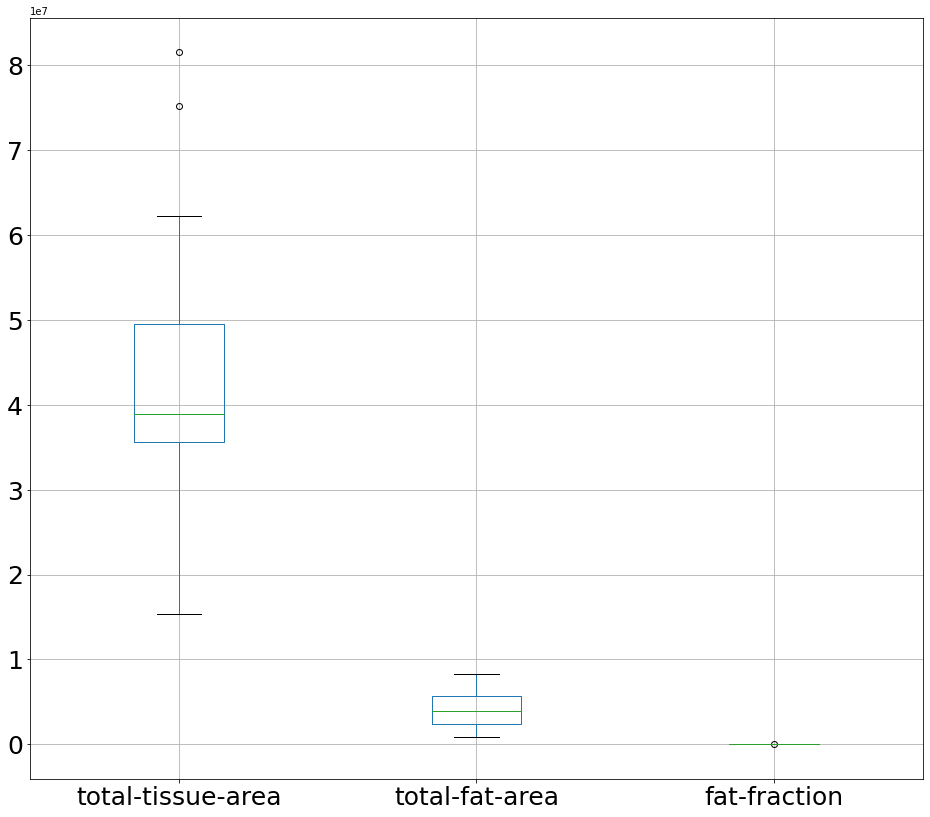

In [71]:
df_results.boxplot(figsize=(16,14), fontsize=25)
plt.show()

# (6) Compare the Oil-Red fat fraction with the H&E manual annotated fat fraction (KW / DA)

### (6.0) Tissue mask - H&E 

In [40]:
#path_original_HE = glob('./data/quantification/tissue_mask/H&E/KW-manual_annotation/*.csv') # KW - H&E
path_original_HE = glob('./data/quantification/tissue_mask/H&E/DA-manual_annotation/*.csv') # DA - H&E

#print(*[x.split('/')[-1] for x in np.sort(path_original_HE)], sep='\n')  
print("\nNumber of samples:", len(path_original_HE))


Number of samples: 17


### (6.1) Tissue mask - Oil-Red

In [41]:
path_original_OilRed = glob('./data/quantification/tissue_mask/Oil-Red/*.csv') # OilRed

#print(*[x.split('/')[-1] for x in np.sort(path_original_OilRed)], sep='\n')  
print("\nNumber of samples:", len(path_original_OilRed))


Number of samples: 17


### (6.2) Fat fraction of manual annotation - H&E

In [43]:
#path_label_HE = glob('./data/quantification/fat/H&E/KW-manual_annotation/*.csv') # KW - H&E
path_label_HE = glob('./data/quantification/fat/H&E/DA-manual_annotation/*.csv') # DA - H&E

#print(*[x.split('/')[-1] for x in np.sort(path_label_HE)], sep='\n')  
print("\nNumber of samples:", len(path_label_HE))


Number of samples: 17


### (6.3) Fat fraction of Oil-Red color thresholding via HSV

In [44]:
path_prediction_OilRed = glob('./data/quantification/fat/Oil-Red/Data/*.csv') # KW - H&E

#print(*[x.split('/')[-1] for x in np.sort(path_prediction_OilRed)], sep='\n')  
print("\nNumber of samples:", len(path_prediction_OilRed))


Number of samples: 17


### (6.4) Merge all information into one table 

In [84]:
arr_all = []

for idx, path_tmp_original_HE in enumerate(path_original_HE):
    
    # get the actual sample
    abbrevation = os.path.splitext(os.path.basename(path_tmp_original_HE))[0]    
    abbrevation = abbrevation.split('#Dataset=')[1]    
    abbrevation = abbrevation.split('_Min Threshold')[0][:5] # HE-KW/DA
        
    ### get paths ###
        
    # get the coresponding Oil-Red tissue mask
    path_tmp_original_OilRed = [x for x in path_original_OilRed if abbrevation in x][0] 
        
    # get the corresponding labeled binary mask of H&E
    path_tmp_label_HE = [x for x in path_label_HE if abbrevation in x][0]
        
    # get the corresponding color thresholded Oil-Red prediction    
    path_tmp_prediction_OilRed = [x for x in path_prediction_OilRed if abbrevation in x][0]
        
    ### determine sums ###    
    
    # determine H&E - tissue mask
    df_original_HE = pd.read_csv(path_tmp_original_HE)
    area_slice_HE = df_original_HE['Area'].sum()
    
    # determine Oil-Red - tissue mask
    df_original_OilRed = pd.read_csv(path_tmp_original_OilRed)
    area_slice_OilRed = df_original_OilRed['Area'].sum()
    
    # determine H&E - fat fraction
    df_label_HE = pd.read_csv(path_tmp_label_HE)
    fat_label_HE = df_label_HE['Area'].sum()
    
    # determine H&E - fat fraction
    df_prediction_OilRed = pd.read_csv(path_tmp_prediction_OilRed)
    fat_prediction_OilRed = df_prediction_OilRed['Area'].sum()
        
    arr = [abbrevation, area_slice_HE, area_slice_OilRed, fat_label_HE, fat_prediction_OilRed]
        
    print(f'[{idx}/{len(path_original)-1}] - sample: {abbrevation} - area slice-HE: {area_slice_HE} - area slice-OilRed: {area_slice_OilRed} - fat from H&E: {fat_label_HE} - fat from Oil-Red: {fat_prediction_OilRed}')
    
    arr_all.append(arr)
    
    #break    

[0/16] - sample: S41.1 - area slice-HE: 94877485 - area slice-OilRed: 49951690 - fat from H&E: 6719256 - fat from Oil-Red: 2973010
[1/16] - sample: GTS01 - area slice-HE: 88521915 - area slice-OilRed: 47595700 - fat from H&E: 1291429 - fat from Oil-Red: 807502
[2/16] - sample: S47.4 - area slice-HE: 50394728 - area slice-OilRed: 32144186 - fat from H&E: 785592 - fat from Oil-Red: 3672099
[3/16] - sample: UTS01 - area slice-HE: 78908123 - area slice-OilRed: 83112167 - fat from H&E: 162943 - fat from Oil-Red: 377890
[4/16] - sample: JTS01 - area slice-HE: 130734829 - area slice-OilRed: 36386824 - fat from H&E: 5653674 - fat from Oil-Red: 814177
[5/16] - sample: GTS01 - area slice-HE: 45853466 - area slice-OilRed: 47595700 - fat from H&E: 1291429 - fat from Oil-Red: 807502
[6/16] - sample: S43.4 - area slice-HE: 100021433 - area slice-OilRed: 49739227 - fat from H&E: 1198606 - fat from Oil-Red: 4862829
[7/16] - sample: UTS02 - area slice-HE: 39329707 - area slice-OilRed: 41245563 - fat fr

### (6.5) Calculate the fat fraction of annotations and predictions 

In [85]:
df_fractions = pd.DataFrame(arr_all, columns=['sample', 'area_slice_HE', 'area_slice_OilRed', 'fat_annotation_HE', 'fat_prediction_OilRed'])

# calculate the fat fraction of annotations and predictions 
df_fractions['fat_fraction_prediction_OilRed'] = df_fractions['fat_prediction_OilRed'] / df_fractions['area_slice_OilRed']
df_fractions['fat_fraction_annotation_HE'] = df_fractions['fat_annotation_HE'] / df_fractions['area_slice_HE']

print(df_fractions.shape, df_fractions.dtypes)
df_fractions

(17, 7) sample                             object
area_slice_HE                       int64
area_slice_OilRed                   int64
fat_annotation_HE                   int64
fat_prediction_OilRed               int64
fat_fraction_prediction_OilRed    float64
fat_fraction_annotation_HE        float64
dtype: object


,sample,area_slice_HE,area_slice_OilRed,fat_annotation_HE,fat_prediction_OilRed,fat_fraction_prediction_OilRed,fat_fraction_annotation_HE
0,S41.1,94877485,49951690,6719256,2973010,0.059518,0.070820
1,GTS01,88521915,47595700,1291429,807502,0.016966,0.014589
2,S47.4,50394728,32144186,785592,3672099,0.114238,0.015589
3,UTS01,78908123,83112167,162943,377890,0.004547,0.002065
4,JTS01,130734829,36386824,5653674,814177,0.022376,0.043245
5,GTS01,45853466,47595700,1291429,807502,0.016966,0.028164
6,S43.4,100021433,49739227,1198606,4862829,0.097766,0.011983
7,UTS02,39329707,41245563,107538,95586,0.002317,0.002734
8,S34.3,72586586,68716386,288142,2407807,0.035040,0.003970
9,JTS04,18980957,46435871,456048,778721,0.016770,0.024027


In [87]:
path_quantitative_results_performance = './data/quantification/fat/'

In [88]:
# optional: save/load the dataframe-table
df_fractions.to_csv(os.path.join(path_quantitative_results_performance, 'fat_fraction.csv'))
#df_fractions = pd.read_csv(os.path.join(path_quantitative_results_performance, 'fat_fraction.csv'), index_col=0)
df_fractions

,sample,area_slice_HE,area_slice_OilRed,fat_annotation_HE,fat_prediction_OilRed,fat_fraction_prediction_OilRed,fat_fraction_annotation_HE
0,S41.1,94877485,49951690,6719256,2973010,0.059518,0.070820
1,GTS01,88521915,47595700,1291429,807502,0.016966,0.014589
2,S47.4,50394728,32144186,785592,3672099,0.114238,0.015589
3,UTS01,78908123,83112167,162943,377890,0.004547,0.002065
4,JTS01,130734829,36386824,5653674,814177,0.022376,0.043245
5,GTS01,45853466,47595700,1291429,807502,0.016966,0.028164
6,S43.4,100021433,49739227,1198606,4862829,0.097766,0.011983
7,UTS02,39329707,41245563,107538,95586,0.002317,0.002734
8,S34.3,72586586,68716386,288142,2407807,0.035040,0.003970
9,JTS04,18980957,46435871,456048,778721,0.016770,0.024027


<Figure size 1152x1152 with 0 Axes>

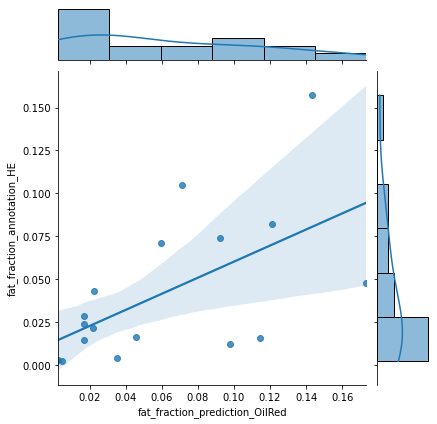

In [89]:
plt.figure(figsize=(16,16))
sns.jointplot(data=df_fractions, x="fat_fraction_prediction_OilRed", y="fat_fraction_annotation_HE", kind="reg")
plt.show()

### (6.6) Plot fat-fraction comparison via seaborn  

No handles with labels found to put in legend.


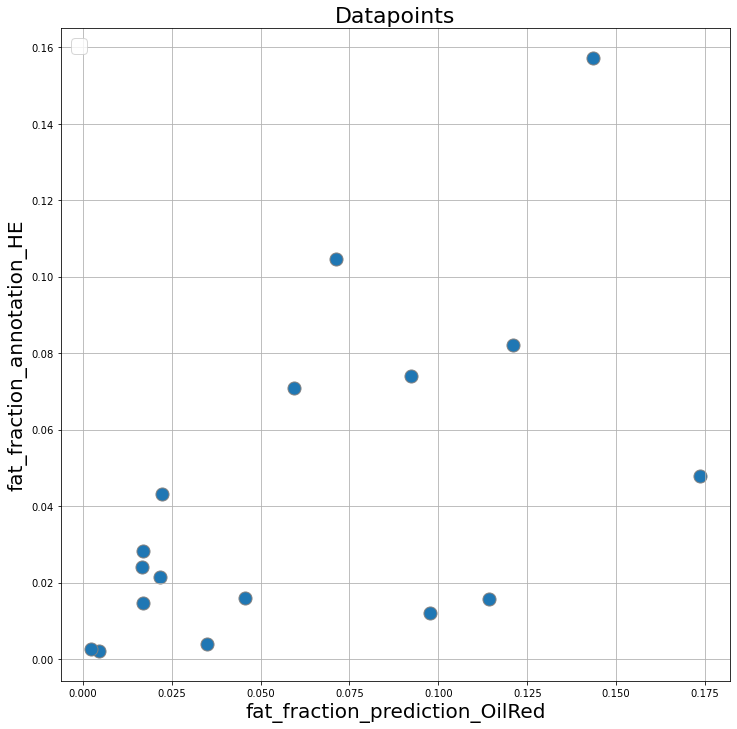

In [90]:
plt.figure(figsize=(12, 12))
plt.grid(True)
hue_order = [str(x) for x in np.arange(8)]

sns.scatterplot(data=df_fractions, x='fat_fraction_prediction_OilRed', y='fat_fraction_annotation_HE', 
    s=170, edgecolor='gray', linewidth=1, palette=sns.color_palette("Set1", 8), hue_order=hue_order)
   
plt.legend(loc='upper left', prop={'size': 20})
#plt.xticks(myticks, fontsize=15); plt.yticks(myticks, fontsize=15)

plt.title('Datapoints', fontsize=22)
plt.xlabel("fat_fraction_prediction_OilRed",fontsize=20)
plt.ylabel("fat_fraction_annotation_HE",fontsize=20)

plt.savefig(os.path.join(path_quantitative_results_performance, 'scatterplot.png'), dpi=300)
plt.show()

### (6.7) Print the correlation of the manual annotations and the predictions

In [91]:
corr_spearman = df_fractions[['fat_fraction_prediction_OilRed', 'fat_fraction_annotation_HE']].corr(method='spearman').iloc[0,1]
corr_pearson = df_fractions[['fat_fraction_prediction_OilRed', 'fat_fraction_annotation_HE']].corr(method='pearson').iloc[0,1]

print('corr_spearman:\t', corr_spearman)
print('corr_pearson:\t', corr_pearson)

corr_spearman:	 0.5996322402351393
corr_pearson:	 0.5793351025735158


### (6.8) Plot KW/DA vs. OilRed 

In [92]:
x_max_value = df_fractions.max()['fat_fraction_prediction_OilRed']
y_max_value = df_fractions.max()['fat_fraction_annotation_HE']

max_value = np.round(np.max([x_max_value, y_max_value]), decimals=2) + .01
max_value

0.18000000000000002

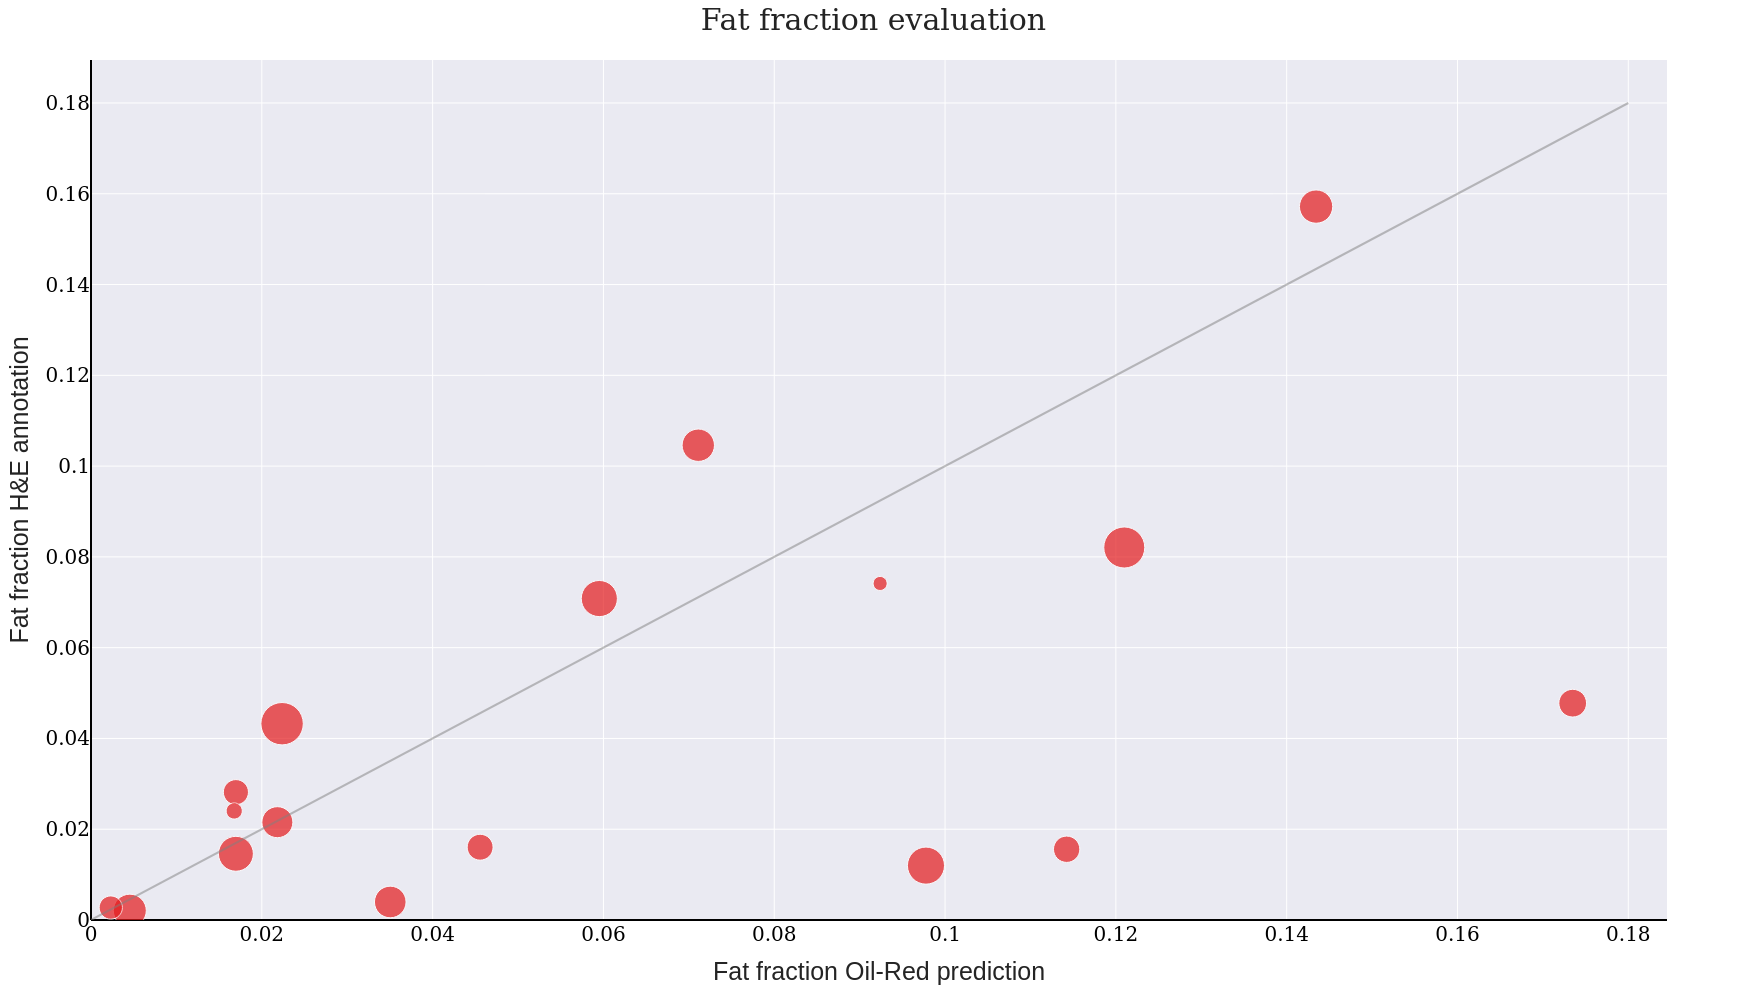

In [93]:
hue_order = [str(x) for x in np.arange(8)]

# without model-id
fig = px.scatter(df_fractions, x="fat_fraction_prediction_OilRed", y="fat_fraction_annotation_HE", size='area_slice_HE', size_max=30, 
                 width=1100, height=1000, color_discrete_sequence=px.colors.qualitative.Set1, opacity=0.7, template="seaborn")


fig.add_trace(
    go.Scatter(
        x=[0, max_value],
        y=[0, max_value],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        opacity=0.5,
        showlegend=False)
)

#fig.update_traces(
#    marker=dict(sizeref=6)
#)

# title
fig.update_layout(
    title=dict(
        text="Fat fraction evaluation"        
    ),
    title_font_family="Candara",
    title_font_size=30
)

# x-axis
fig.update_xaxes(
    title="Fat fraction Oil-Red prediction",
    title_font_size=25,
    showticklabels=True,
    rangemode="tozero",
    #tick0=0.02, 
    #dtick=0.01,
    range=[0, max_value],
    tickfont=dict(
        family="Candara",
        size=20,
        color="Black"
    ),
    zerolinewidth=2, 
    zerolinecolor='black'
)

# y-axis
fig.update_yaxes(
    title="Fat fraction H&E annotation",
    title_font_size=25,
    showticklabels=True,
    rangemode="tozero",
    #tick0=0.02, 
    #dtick=0.01,
    range=[0, max_value],
    tickfont=dict(
        family="Candara",
        size=20,
        color="Black"
    ),
    zerolinewidth=2, 
    zerolinecolor='black'
)

# grid
fig.update_layout(
    grid=dict(xgap=0.1, ygap=0.1)
)

fig.show()

fig.write_html(os.path.join(path_quantitative_results_performance, "fat-fraction.html"), include_plotlyjs="cdn")
fig.write_image(file=os.path.join(path_quantitative_results_performance, "fat-fraction.png"), format="png")
fig.write_image(file=os.path.join(path_quantitative_results_performance, "fat-fraction.svg"), format="svg")